In [0]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
cat_doodles = np.load('/content/gdrive/My Drive/cats.npy')

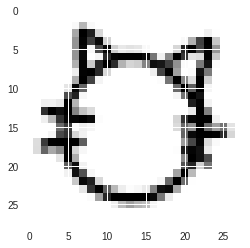

In [19]:
X_train = (cat_doodles.astype(np.float32)/127.5) - 1. #normalize to be [-1,1]
num_train = X_train.shape[0]
X_train = X_train.reshape(num_train, 28, 28, 1)
random_cat = X_train[np.random.randint(num_train-1)].reshape(28, 28)
random_cat = random_cat*127.5 + 1
plt.imshow(random_cat) #a wild random cat appears

In [0]:
from tqdm import tqdm
from keras.models import Sequential, Model
from keras.layers import Input, Dense, BatchNormalization, Dropout, Flatten
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, Reshape, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, SGD
from keras.initializers import RandomNormal
from keras.backend import clear_session
np.random.seed(0)

In [0]:
class DCGAN():
  
  def __init__(self):
      self.img_rows = 28
      self.img_cols = 28
      self.img_shape = (self.img_rows, self.img_cols, 1)
      self.latent_dim = 100

      self.optimizer = Adam(0.0002, 0.5)

      # Build and compile the discriminator
      self.discriminator = self.build_discriminator()
      self.discriminator.compile(loss='binary_crossentropy', optimizer=self.optimizer)

      # Build and compile the generator
      self.generator = self.build_generator()
      self.generator.compile(loss='binary_crossentropy', optimizer=self.optimizer)

      self.gan = self.build_GAN()
  
  def build_GAN(self):
      self.discriminator.trainable = False
      gan_input = Input(shape=(self.latent_dim,))
      img = self.generator(gan_input)
      
      gan_output = self.discriminator(img)
      gan = Model(gan_input, gan_output, name='GAN')
      gan.compile(loss='binary_crossentropy', optimizer=self.optimizer)
      gan.summary()
      
      return gan
    
  def build_generator(self):
    
      generator = Sequential()
      generator.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
      generator.add(Reshape((7, 7, 128)))
      generator.add(BatchNormalization(momentum=0.8))
      generator.add(UpSampling2D())
      generator.add(Conv2D(128, kernel_size=3, padding="same"))
      generator.add(LeakyReLU(0.2))
      generator.add(BatchNormalization(momentum=0.8))
      generator.add(UpSampling2D())
      generator.add(Conv2D(64, kernel_size=3, padding="same"))
      generator.add(LeakyReLU(0.2))
      generator.add(BatchNormalization(momentum=0.8))
      generator.add(Conv2D(1, kernel_size=3, padding='same', activation = "tanh"))
      generator.summary()

      noise = Input(shape=(self.latent_dim,))
      img = generator(noise)

      return Model(noise, img, name='Generator')

  def build_discriminator(self):

      discriminator = Sequential()
      discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', 
                               input_shape=self.img_shape, kernel_initializer=RandomNormal(stddev=0.02)))
      discriminator.add(LeakyReLU(0.2))
      discriminator.add(Dropout(0.2))
      discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
      discriminator.add(LeakyReLU(0.2))
      discriminator.add(Dropout(0.2))
      discriminator.add(Flatten())
      discriminator.add(Dense(1, activation='sigmoid'))
      discriminator.summary()

      img = Input(shape=self.img_shape)
      validity = discriminator(img)

      return Model(img, validity, name='Discriminator')
 

  def train(self, X_train, epochs, batch_size=128, sample_interval=50):

      real = np.ones((batch_size, 1))
      fake = np.zeros((batch_size, 1))
      avg_losses = {'D': [], 'G': []}
      num_batches = len(X_train) // batch_size
      for epoch in range(epochs):
          d_loss_acc = 0
          g_loss_acc = 0
          for i in range(num_batches):
            
            #Random batch of real doodles
            imgs = X_train[np.random.randint(0, len(X_train) - 1, batch_size)]

            #Generate a batch of doodles
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            self.discriminator.trainable = True

            #Train the discriminator (add random smoothing to labels)
            d_loss_real = self.discriminator.train_on_batch(imgs, real * (np.random.uniform(0.7, 1.2)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake + (np.random.uniform(0.0, 0.3)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            #We don't want the discriminator to get updated while the generator is being trained
            self.discriminator.trainable = False
            
            #Train the generator
            g_loss = self.gan.train_on_batch(noise, real)            

#             if i % 100 == 0:
#               print ("EPOCH:", epoch, "D LOSS", d_loss, "G LOSS:", g_loss)
            
            d_loss_acc += d_loss
            g_loss_acc += g_loss

          #Print samples
          if (epoch + 1) % sample_interval == 0 or epoch == 0:
              self.sample_images(epoch)
          
          avg_losses['D'].append(d_loss_acc/num_batches)
          avg_losses['G'].append(g_loss_acc/num_batches)
      
      self.plot_loss(avg_losses)
              
  def sample_images(self, epoch):
    num_examples = 100
    random_noise = np.random.normal(0, 1, size=[num_examples, self.latent_dim])
    generated_images = self.generator.predict(random_noise)
    generated_images = generated_images.reshape(num_examples, 28, 28)*127.5 + 1

    plt.figure(figsize=(10, 10))
    for i in range(generated_images.shape[0]):
        plt.subplot(10, 10, i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    
    plt.suptitle("Samples from G - Epoch = " + str(epoch+1))
    plt.show()
  
  def plot_loss(self, losses):
     
      plt.figure(figsize=(10, 8))
      plt.plot(losses["D"], label="Discriminator loss")
      plt.plot(losses["G"], label="Generator loss")
   
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.legend()
      plt.title("Loss History")
      plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_59 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_60 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 6272)              0         
__________

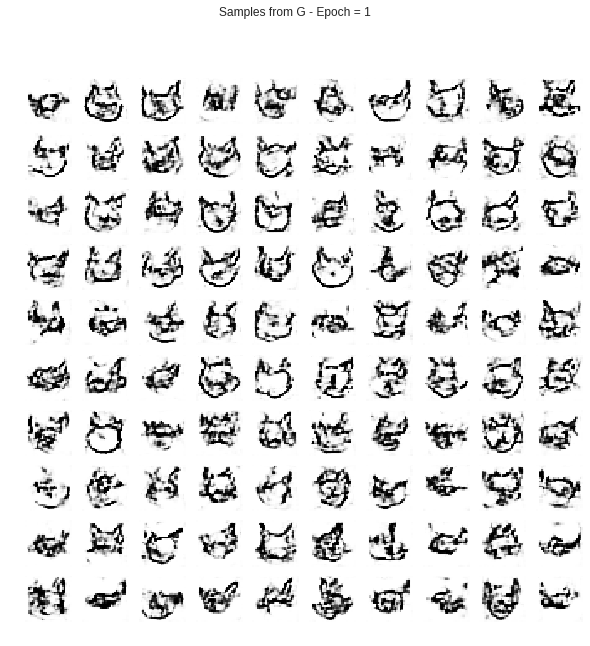

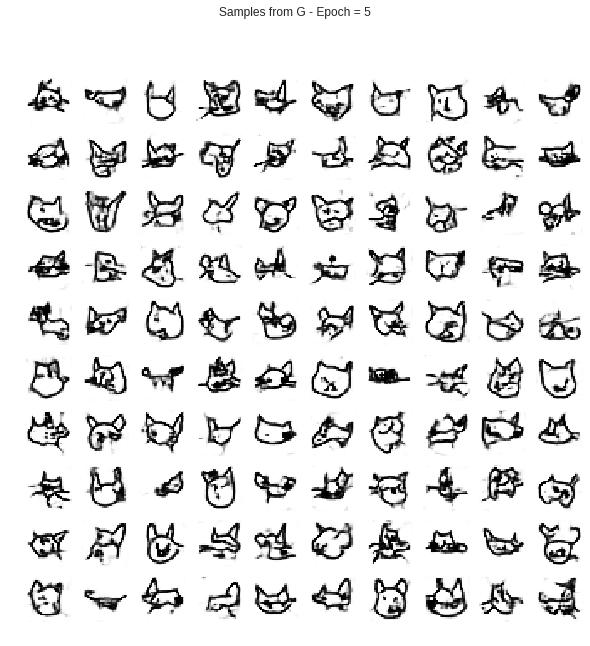

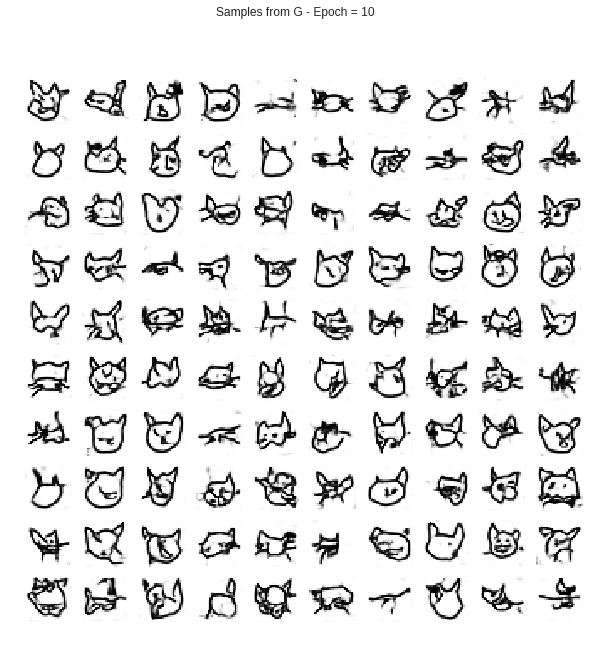

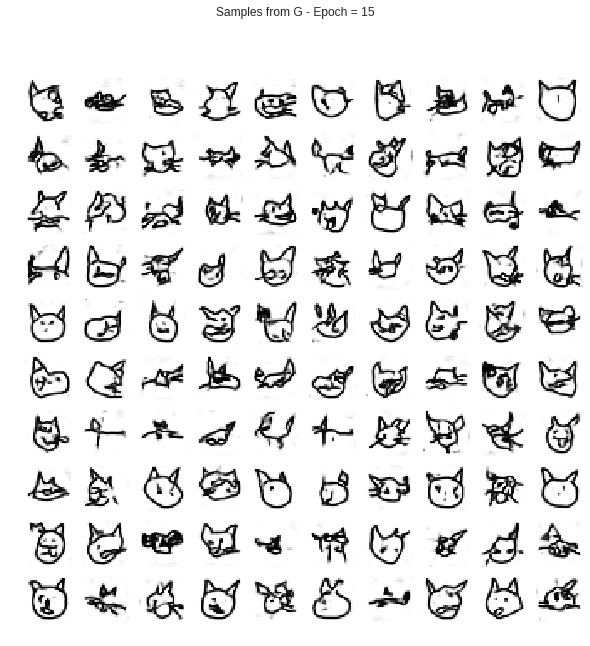

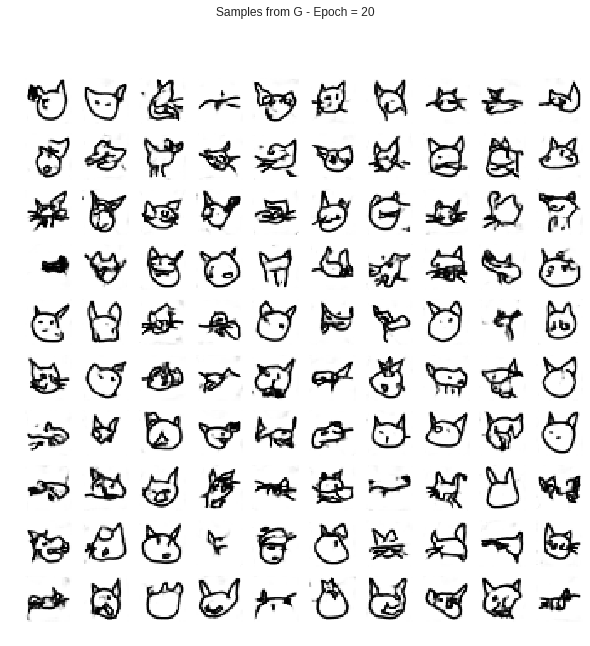

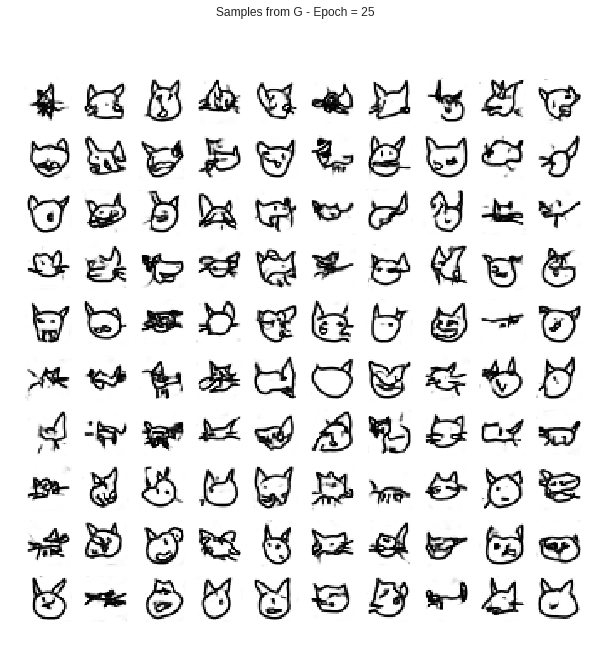

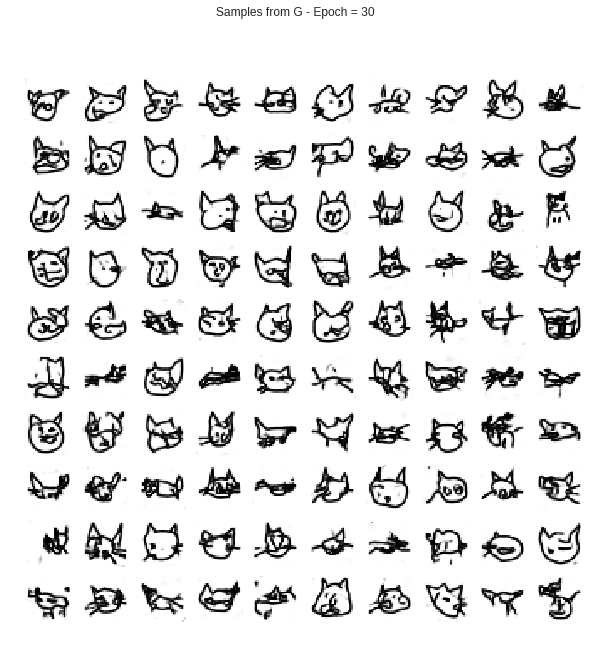

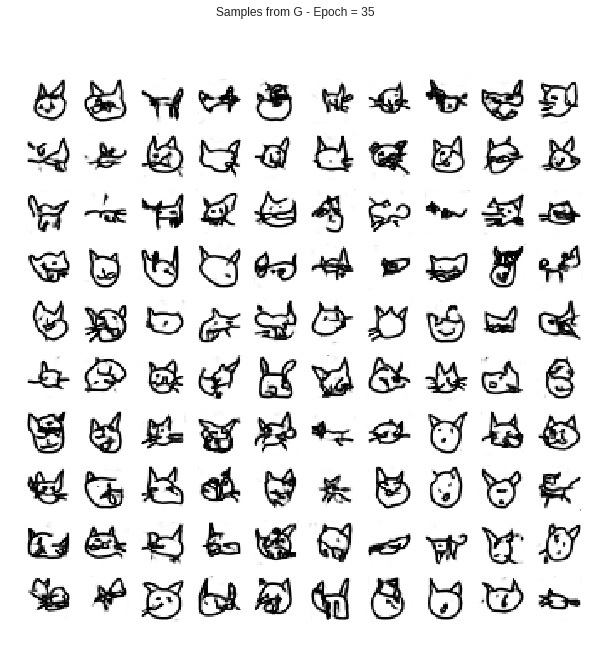

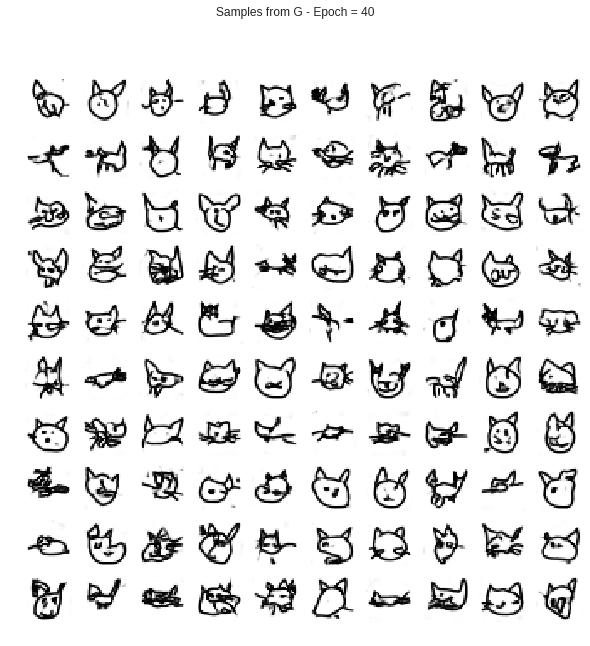

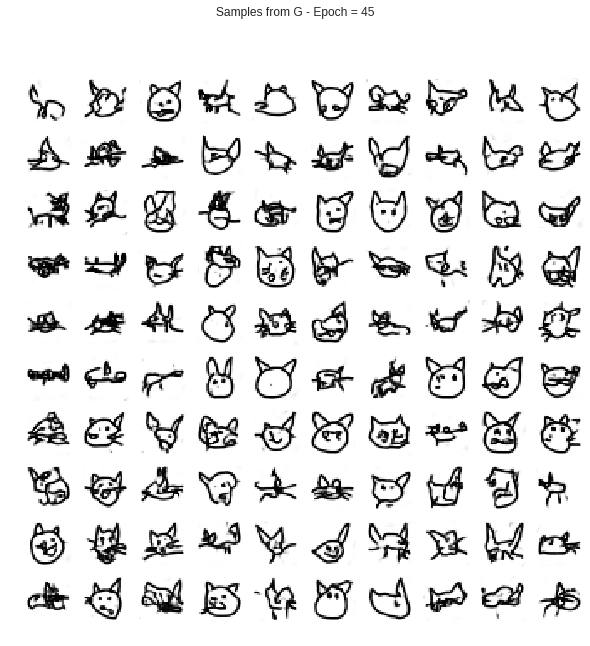

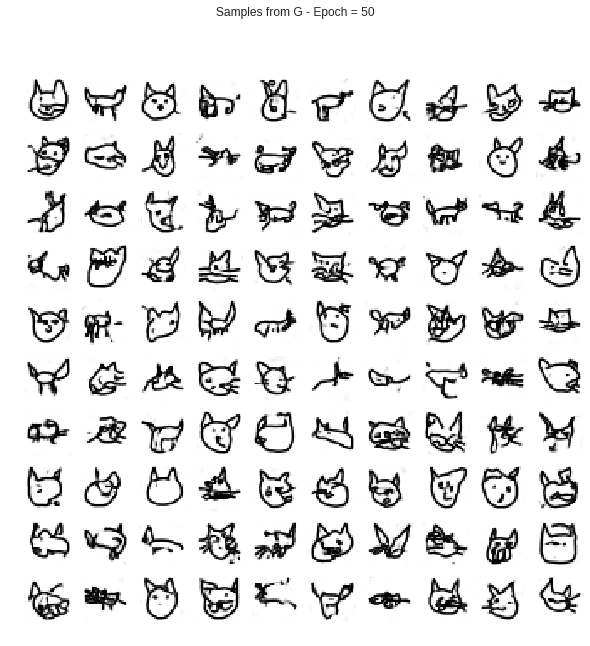

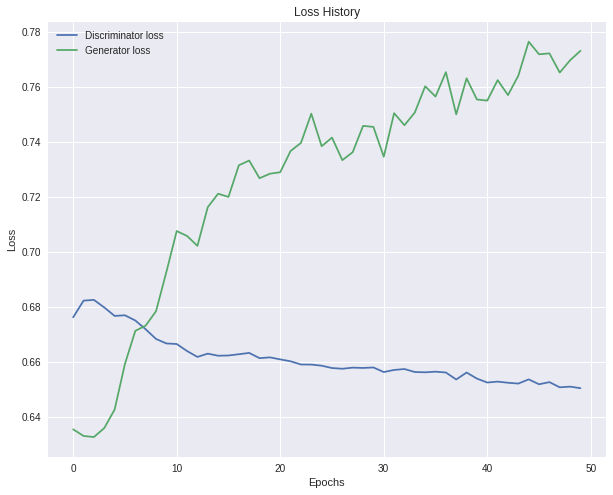

In [57]:
gan = DCGAN()
gan.train(X_train, epochs=50, batch_size=128, sample_interval=5)